# Star Trail Image Stacker

### Using a Neural Network that Highlights Star-Like features

To counteract the problem described in [README.md](./README.md), the same Lighten blending can be applied only to selected pixels of a layer that contain a "star". In this case, the mask is generated by passing the image through a neural network trained to generate a black & white output image of the same size from it, in which pixels containing stars are "highlighted"/bright, while everything else is dark. The result is then used to lighten-blend the image in sequence with its previous one as a regular mask.

Details about the neural network are in [nn.ipynb](./nn.ipynb).

-------

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob, os

# import ipywidgets as widgets
import IPython.display as disp
from tqdm.notebook import tqdm

# list available backends
# 'widget' backend allows interactive plots within the notebook
# Matplotlib is convenient for zooming into the image and viewing pixel coordinates/values
%matplotlib -l      
%matplotlib inline
# 'inline' is not interactive like 'widget' but images get saved to the notebook file; viewable without running the code


Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


#### 1. Select Images

- Specify the paths to input images as a list in `SOURCE_PATH`. If it is a serially numbered image sequence, wildcards such as `*`, `[]`, etc can be used with `glob` to generate the list automatically.
- `BASE_PATH` contains the path of a single image which will form the bottom-most layer of the image stack. All the other source images are blended together above this, and only their edge-regions will appear above it, while the rest of the background will be the same as that of this image.


In [2]:
print("Current Working Directory :", os.getcwd())

SOURCE_PATH = glob.glob("./data/JPEG/*.jpg")
BASE_PATH   = "./data/JPEG/4J7A6511.jpg"

SOURCE_PATH.sort()

if not SOURCE_PATH:
    raise FileNotFoundError("Please set a valid image sequence path for SOURCE_PATH")
if not os.path.isfile(BASE_PATH):
    raise FileNotFoundError("Please set a valid image path for BASE_PATH")


_abs_source = list(map(os.path.abspath, SOURCE_PATH))
if os.path.abspath(BASE_PATH) in _abs_source:
    SOURCE_PATH.pop(_abs_source.index(os.path.abspath(BASE_PATH)))


Current Working Directory : /Users/gautamd/Home/github/startrail-merger


In [3]:
def displayimg(arr, title=None, figsize=(12, 8), close=None):
    """Use matplotlib to display an image"""
    
    fax = fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(tf.keras.utils.array_to_img(arr))
    if title :
        ax.set_title(title)
    fig.subplots_adjust(bottom=0, top=1, left=0.1, right=0.9)
    if isinstance(close, plt.Figure) :
        plt.close(close)
    return fax


#### 2. Slice

To reduce the time taken to re-process the entire image everytime any parameters are tweaked, you can choose to just process a sub-section of the image.
Specify

```SLICE = (x1, y1, x2, y2)``` 

in the code cell below to identify the top-left (x1, y1) and bottom-right (x2, y2) of the rectangular region to process.
- Use `SLICE = (0, 0, *baseImg.shape[:2])` to select the entire Image

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Base Image'}>)

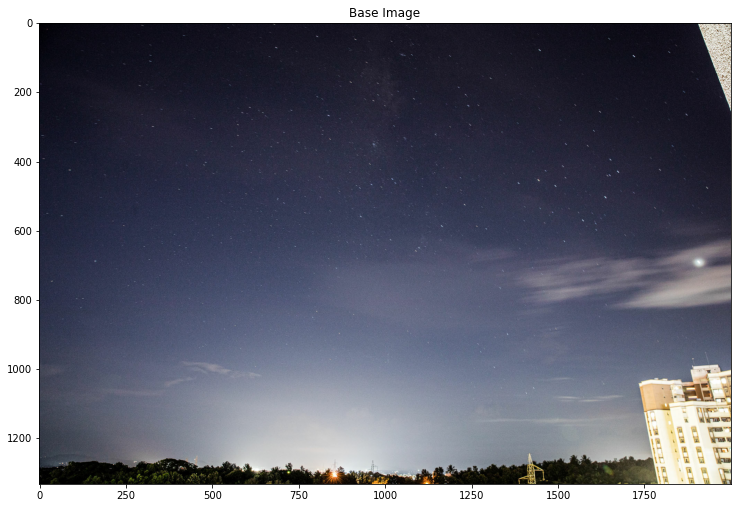

In [4]:
baseImg = tf.io.decode_image(tf.io.read_file(BASE_PATH))

SLICE = (0, 0, *tuple(baseImg.shape)[1::-1])
# SLICE = (2000, 500, 3500, 1500)

assert SLICE[2] > SLICE[1] >= 0 and SLICE[3] > SLICE[0] >= 0, "Invalid bounding box"

displayimg(baseImg[SLICE[0]:SLICE[3], SLICE[1]:SLICE[2]], "Base Image")

#### 3. Preprocess

One of the drawbacks of using the neural network is that it can't directly process images of any type/size. The one used here, trained in `nn.ipynb`, accepts a Tensor of shape $128 \times 128 \times 1$ *(width, height, grayscale value)* as input. The image is padded with extra pixels if necessary and converted into a stack of such data arrays, which can then be passed through the neural network. After that, it is reconstructed. Additionally, even the pixel values are normalized to the `0.0 - 1.0` range for the network, and readjusted afterwards.

In [5]:
nn = tf.keras.models.load_model('data/CNNmodel')

print("Expected dimensions of image batch (batchsize, w, h, bands) - ", nn.input_shape)
BATCH_DIM = nn.input_shape[1:3]


def preprocess(img, nw_offset=0, slice_size=BATCH_DIM,):
    """Normalise the image colours; split it into multiple pieces
    of required width/height & stack them into a 4D tensor.
    Pad borders with the average colour in the image if dimensions
    aren't an exact multiple."""
    h, w, bands = img.shape
    dx, dy = slice_size
    h += nw_offset; w += nw_offset
    if bands > 3:
        img = img[:,:,:3]
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.float32) / 255.0
    padding = tf.constant([
      [nw_offset, dy-h%dy if h%dy else 0], 
      [nw_offset, dx-w%dx if w%dx else 0], 
      [0, 0]
    ])
    full = tf.pad(img, padding,
      constant_values=tf.math.reduce_mean(img))
    
    slices = []
    for y in range(0,h,dy):
        for x in range(0,w,dx):
            slices.append(full[y:y+dy, x:x+dx, :])

    return tf.stack(slices)


def reconstruct(img_stack, w, h, nw_offset=0, norm_factor=1):
    """Unstack the 4D output of the neural network into a 3D tensor
    (output image), the reverse of `reconstruct`.
    Also normalise intensity of colours in the output."""
    ny = np.ceil((h+nw_offset)/BATCH_DIM[0]).astype(int)
    nx = np.ceil((w+nw_offset)/BATCH_DIM[1]).astype(int)
    reconstructed = tf.concat([
        tf.concat([
            img_stack[x] for x in range(nx*y, nx*(y+1))
        ], axis=1)
        for y in range(ny)
    ], axis=0)
    og_shape = reconstructed[nw_offset : h+nw_offset, 
                             nw_offset : w+nw_offset, :]
    mi, ma = og_shape.numpy().min(), og_shape.numpy().max()
    if ma==mi :
        processed = og_shape * 0
    else :
        processed = tf.clip_by_value((og_shape-mi) * norm_factor/(ma-mi),
                          0.0, 1.0)
    return processed


Expected dimensions of image batch (batchsize, w, h, bands) -  (None, 128, 128, 1)


#### 4. Blending

Another problem with the neural network is that its ability to detect stars equally well in the centre of the `128x128` section differs from the same kind of star on the edge of the image. (On the edge, it is usually slightly distorted or fainter; but this is enough to notice a distinct grid pattern in the final result, along lines where the image has been split during preprocessing and then recombined.) <br> The `level` variable is used in the `reconstruct` function to "threshold" the mask values.

To prevent this, the mask is generated for *twice* for each image, once normally & then once more offset by 64 pixels / half of each section's size, and these 2 are re-aligned and combined by another lighten-blend (brighter pixels retained). Now, the final mask has no visible effects and is used to mask the original image by multiplication with it.

### Selective Blending Result

  0%|          | 0/31 [00:00<?, ?it/s]

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Result using the mask generated by Neural Network'}>)

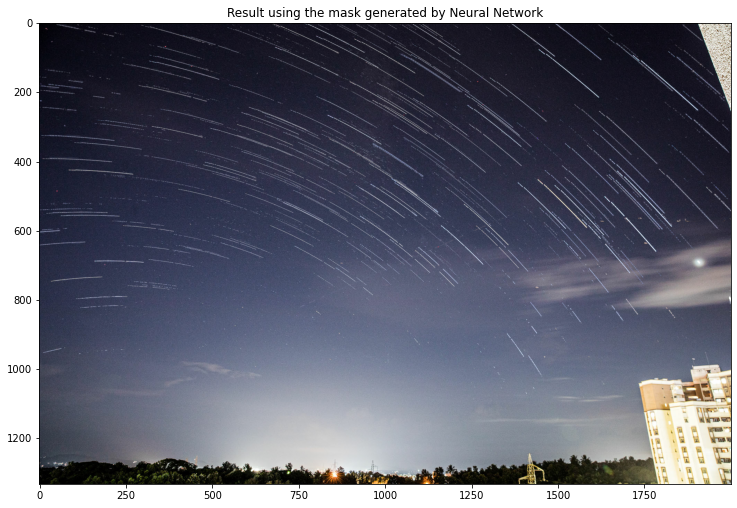

In [6]:

disp.display(disp.Markdown("### Selective Blending Result"))

"""
Change the arguments in the function below :

- LEVEL : `float`, > 0.0

- SAVE      : `bool`
- OVERWRITE : `bool`
"""

imgView = None

# @widgets.interact_manual(level=(1,10,0.1), save=False, overwrite=False)
def blend(level=7., save=False, overwrite=False):
    
    global imgView
    
    imgStack = baseImg[SLICE[0]:SLICE[3], SLICE[1]:SLICE[2]]
    
    for p in tqdm(SOURCE_PATH) :
        img = tf.io.decode_image(tf.io.read_file(p))[SLICE[0]:SLICE[3], SLICE[1]:SLICE[2]]
        h, w, bands = img.shape
        pad = int(BATCH_DIM[0]/2)
        mask_a = reconstruct(nn(preprocess(img, 0)), w, h, 0, level)
        mask_b = reconstruct(nn(preprocess(img, pad)), w, h, pad, level)
        mask = tf.math.maximum(mask_a, mask_b)

        select = tf.cast(tf.cast(img, mask.dtype) * mask, img.dtype)
        imgStack = tf.math.maximum(imgStack, select)

        if save:
            if not os.path.isdir('./processed'):
                os.mkdir('./processed')
            p = './processed/'+os.path.split(p)[1]
            if os.path.isfile(p):
                if overwrite : os.remove(p)
                else : raise FileExistsError(f"{os.path.abspath(p)} cannot be replaced. You must enable the 'overwrite' option")
            tf.keras.utils.save_img(p, imgStack.numpy())
            print("saving", os.getcwd()+'/processed/'+os.path.split(p)[1])

    imgView = displayimg(imgStack, "Result using the mask generated by Neural Network", close=imgView)
    return imgView

blend()


-----

#### Regular/Direct Blending

The following cell also blends the images, but without computing any mask (directly lighten the whole image, hence there are no parameters).
This can be used as a 'control' to compare with the previous result.

Images are saved at `./processed/d_{filename}` if enabled.

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Ordinary Result'}>)

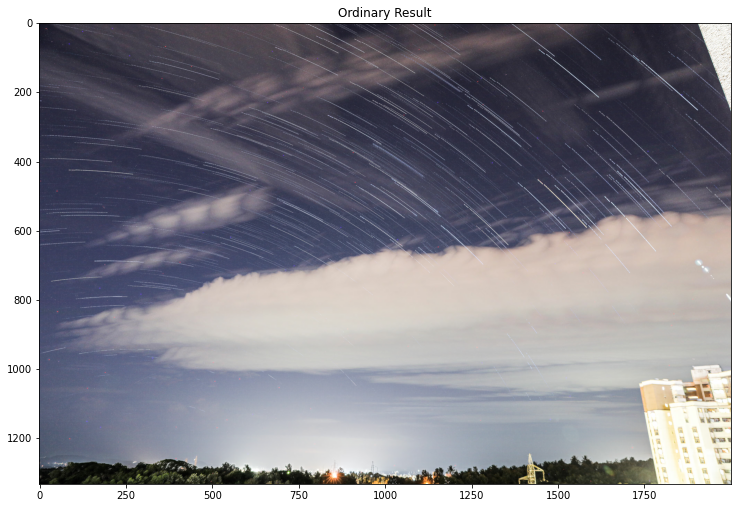

In [7]:

"""
Change the arguments in the function below :

- SAVE      : `bool`
- OVERWRITE : `bool`
"""

imgViewDt  = None

def blend_direct(save=False, overwrite=False):

    global imgViewDt
    
    imgStackDt = baseImg[SLICE[0]:SLICE[3], SLICE[1]:SLICE[2]]

    for ipath in SOURCE_PATH:
        img = tf.io.decode_image(tf.io.read_file(ipath))[SLICE[0]:SLICE[3], SLICE[1]:SLICE[2]]
        imgStackDt = tf.math.maximum(img, imgStackDt)
        
        if save:
            if not os.path.isdir('./processed'):
                os.mkdir('./processed')
            p = './processed/d_'+os.path.split(ipath)[1]
            if os.path.isfile(p):
                if overwrite : os.remove(p)
                else : raise FileExistsError(f"{os.path.abspath(p)} cannot be replaced. You must enable the 'overwrite' option")
            tf.keras.utils.save_img(p, imgStackDt.numpy())
            print("saving", os.getcwd()+'/processed/'+os.path.split(ipath)[1])

    imgViewDt = displayimg(imgStackDt, "Ordinary Result", close=imgViewDt)
    return imgViewDt
    
blend_direct()


In [8]:
plt.show()